***Detect cracks in metallic/ceramic surfaces using classical image techniques***

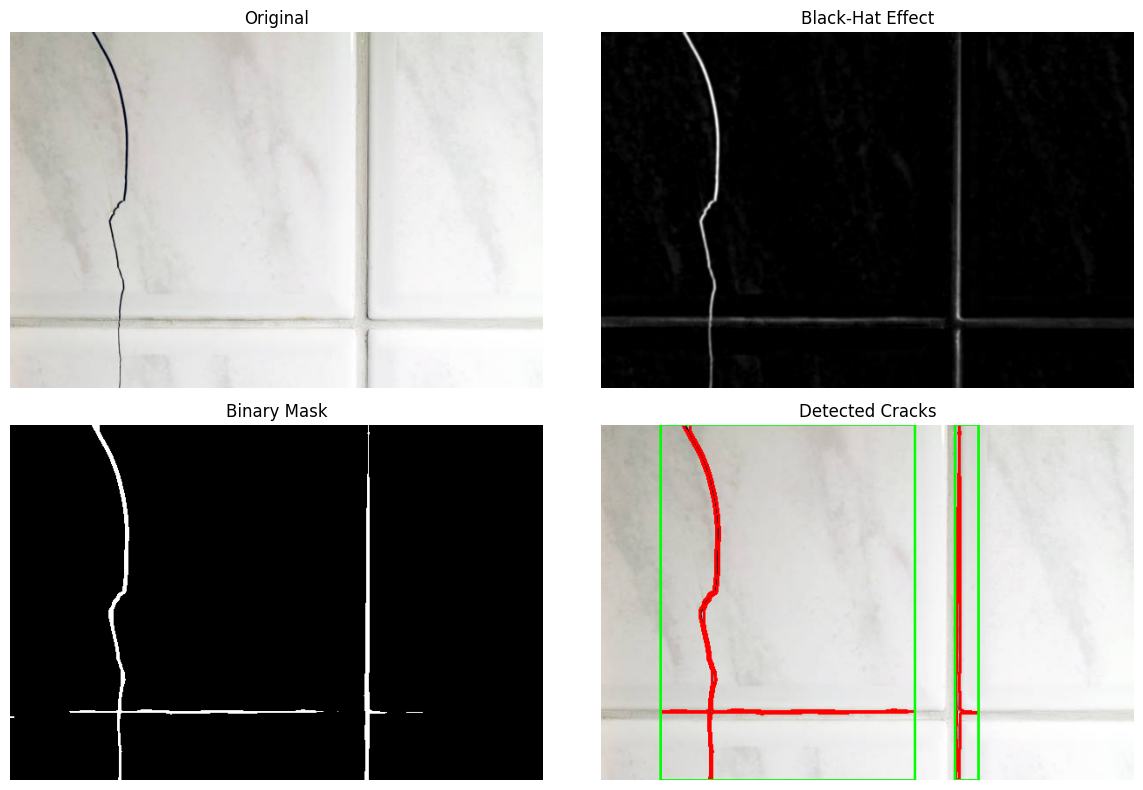

Crack Detected!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_crack(image_path, min_area=100):
    original = cv2.imread(image_path)
    if original is None:
        print(f"Error: Could not load image {image_path}")
        return

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size)
    blackhat = cv2.morphologyEx(blurred, cv2.MORPH_BLACKHAT, kernel)

    _, binary = cv2.threshold(blackhat, 30, 255, cv2.THRESH_BINARY)

    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_cracks_img = original.copy()
    crack_found = False

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            crack_found = True
            cv2.drawContours(detected_cracks_img, [cnt], -1, (0, 0, 255), 2)

            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(detected_cracks_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(12, 8))

    titles = ['Original', 'Black-Hat Effect', 'Binary Mask', 'Detected Cracks']
    images = [cv2.cvtColor(original, cv2.COLOR_BGR2RGB), blackhat, binary, cv2.cvtColor(detected_cracks_img, cv2.COLOR_BGR2RGB)]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i], cmap='gray' if i==1 or i==2 else None)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if crack_found:
        print("Crack Detected!")
    else:
        print("No significant cracks found.")
detect_crack('/content/1.00001bcc92282a38.jpg')

***Implement crack detection using ResNet/U Net on a crack image dataset***

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

print("Path to dataset files:", path)

100%|██████████| 26.4M/26.4M [00:00<00:00, 167MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kaustubhdikshit/neu-surface-defect-database/versions/1


Dataset missing. Generating 100 synthetic images in 'crack_dataset'...
Generation Complete.
Loading data into memory...
Data Loaded. Images: (100, 128, 128, 1), Masks: (100, 128, 128, 1)
Starting Training...
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 933ms/step - accuracy: 0.5980 - loss: 0.5505 - val_accuracy: 0.9901 - val_loss: 0.1335
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 772ms/step - accuracy: 0.9901 - loss: 0.1045 - val_accuracy: 0.9901 - val_loss: 0.0742
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 891ms/step - accuracy: 0.9891 - loss: 0.0583 - val_accuracy: 0.9901 - val_loss: 0.0463
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 910ms/step - accuracy: 0.9896 - loss: 0.0474 - val_accuracy: 0.9901 - val_loss: 0.0411
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 892ms/step - accuracy: 0.9895 - loss: 0.0403 - val_accuracy: 0.9901 - val_loss: 0.0342
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - accuracy: 0.9894 - loss: 0.0349 - val_accuracy: 0.9901 - val_loss: 0.0285
Epoch 7/10
12/12 ━

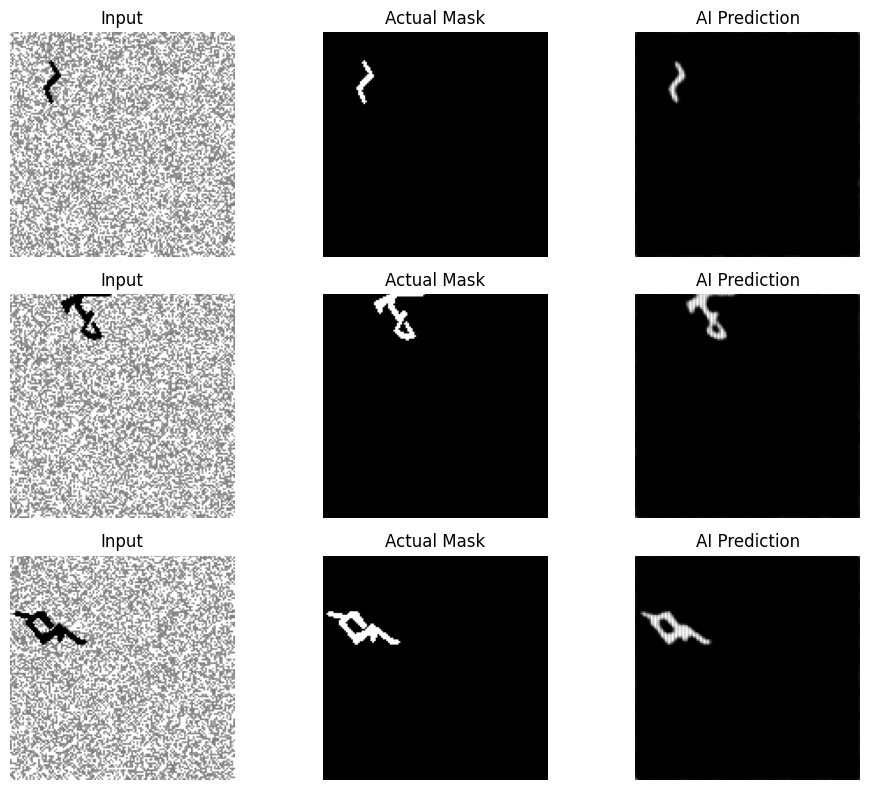

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

def generate_dataset_if_missing(base_dir="crack_dataset", count=100, img_size=128):
    image_dir = os.path.join(base_dir, "images")
    mask_dir = os.path.join(base_dir, "masks")

    if os.path.exists(image_dir) and len(os.listdir(image_dir)) > 0:
        print("Dataset found. Skipping generation.")
        return

    print(f"Dataset missing. Generating {count} synthetic images in '{base_dir}'...")
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    for i in range(count):
        img = np.full((img_size, img_size), 150, dtype=np.uint8)
        noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
        img = cv2.add(img, noise)

        mask = np.zeros((img_size, img_size), dtype=np.uint8)

        pts = []
        x = random.randint(0, img_size)
        y = random.randint(0, img_size)

        for _ in range(random.randint(5, 15)):
            pts.append([x, y])
            x += random.randint(-10, 10)
            y += random.randint(-10, 10)
            x = np.clip(x, 0, img_size-1)
            y = np.clip(y, 0, img_size-1)

        pts = np.array(pts, np.int32).reshape((-1, 1, 2))

        cv2.polylines(img, [pts], False, (50), thickness=2)
        cv2.polylines(mask, [pts], False, (255), thickness=2)

        cv2.imwrite(os.path.join(image_dir, f"{i}.png"), img)
        cv2.imwrite(os.path.join(mask_dir, f"{i}.png"), mask)

    print("Generation Complete.")

IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 1
BATCH_SIZE = 8
EPOCHS = 10

generate_dataset_if_missing()

def load_data(path):
    images = []
    masks = []

    img_dir = os.path.join(path, "images")
    mask_dir = os.path.join(path, "masks")

    files = sorted(os.listdir(img_dir))

    for f in files:
        try:
            img_path = os.path.join(img_dir, f)
            mask_path = os.path.join(mask_dir, f)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

            img = img / 255.0
            mask = mask / 255.0

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Skipping bad file {f}: {e}")

    return np.array(images), np.array(masks)

print("Loading data into memory...")
X, y = load_data("crack_dataset")
print(f"Data Loaded. Images: {X.shape}, Masks: {y.shape}")

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return models.Model(inputs=[inputs], outputs=[outputs])

model = build_unet((IMG_WIDTH, IMG_HEIGHT, CHANNELS))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Starting Training...")
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1)

print("Visualizing Predictions...")
ix = np.random.randint(0, len(X), 3)
preds = model.predict(X[ix])

plt.figure(figsize=(10, 8))
for i in range(len(ix)):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(X[ix[i]].squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(y[ix[i]].squeeze(), cmap='gray')
    plt.title("Actual Mask")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("AI Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

***Classify a crack segmentation task into calibrated width measurements and severity classes (narrow/medium/wide).***

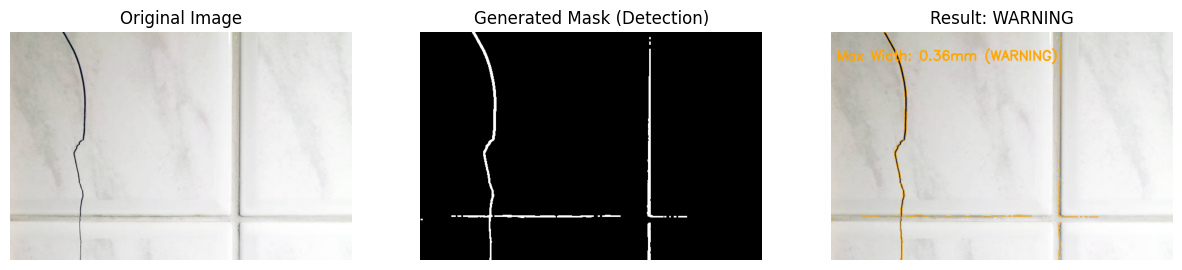

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_and_measure(image_path):
    if not os.path.exists(image_path):
        print(f"ERROR: File not found at {image_path}")
        return

    original = cv2.imread(image_path)
    if original is None:
        print("ERROR: Image could not be read. Check file format.")
        return

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(blurred, cv2.MORPH_BLACKHAT, kernel)

    _, binary_mask = cv2.threshold(blackhat, 25, 255, cv2.THRESH_BINARY)

    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3,3)))

    if cv2.countNonZero(binary_mask) == 0:
        print("No crack detected. Try adjusting threshold.")
        return

    PIXEL_TO_MM_RATIO = 0.05

    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

    max_width_px = np.max(dist_transform) * 2
    mean_width_px = np.mean(dist_transform[binary_mask > 0]) * 2

    max_width_mm = max_width_px * PIXEL_TO_MM_RATIO
    mean_width_mm = mean_width_px * PIXEL_TO_MM_RATIO

    severity = "SAFE"
    color = (0, 255, 0)

    if max_width_mm > 1.0:
        severity = "CRITICAL"
        color = (0, 0, 255)
    elif max_width_mm > 0.3:
        severity = "WARNING"
        color = (0, 165, 255)

    heatmap = cv2.applyColorMap(np.uint8(cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX)), cv2.COLORMAP_JET)
    heatmap[binary_mask == 0] = 0

    result_img = original.copy()
    text = f"Max Width: {max_width_mm:.2f}mm ({severity})"
    cv2.putText(result_img, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(result_img, contours, -1, color, 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Generated Mask (Detection)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Result: {severity}")
    plt.axis("off")

    plt.show()

detect_and_measure('/content/1.00001bcc92282a38.jpg')

***Detect the weld seam and flag discontinuities under noisy, site like conditions.***

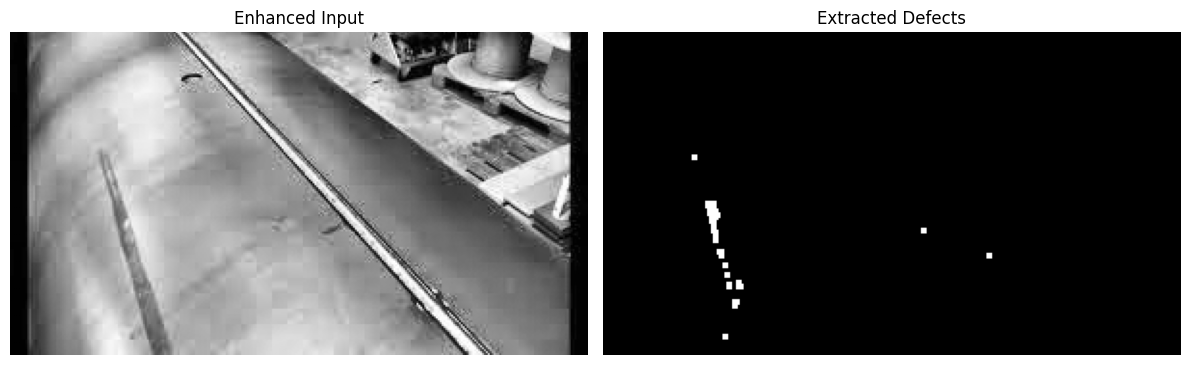

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inspect_weld_seam(image_path):
    original = cv2.imread(image_path)
    if original is None:
        print("Error: Image not found.")
        return

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    blur_roi = cv2.GaussianBlur(enhanced, (25, 25), 0)
    _, weld_binary = cv2.threshold(blur_roi, 130, 255, cv2.THRESH_BINARY)

    kernel_roi = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
    weld_mask = cv2.morphologyEx(weld_binary, cv2.MORPH_OPEN, kernel_roi)

    contours, _ = cv2.findContours(weld_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No weld seam detected.")
        return

    largest_cnt = max(contours, key=cv2.contourArea)
    weld_mask_clean = np.zeros_like(gray)
    cv2.drawContours(weld_mask_clean, [largest_cnt], -1, 255, -1)
    weld_only = cv2.bitwise_and(enhanced, enhanced, mask=weld_mask_clean)

    defects_binary = cv2.adaptiveThreshold(
        weld_only, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 10
    )

    defects_binary = cv2.bitwise_and(defects_binary, defects_binary, mask=weld_mask_clean)
    kernel_defect = np.ones((3,3), np.uint8)
    defects_binary = cv2.morphologyEx(defects_binary, cv2.MORPH_OPEN, kernel_defect)

    result_img = original.copy()

    cv2.drawContours(result_img, [largest_cnt], -1, (255, 0, 0), 2)

    defect_contours, _ = cv2.findContours(defects_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    defect_count = 0
    for cnt in defect_contours:
        area = cv2.contourArea(cnt)
        if 10 < area < 500:
            defect_count += 1
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(result_img, "Defect", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    plt.figure(figsize=(12, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Enhanced Input")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(defects_binary, cmap='gray')
    plt.title("Extracted Defects")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

inspect_weld_seam('/content/images.jpg')

***Implement PCB inspection via template matching***

--- TEST 1: Golden Board ---


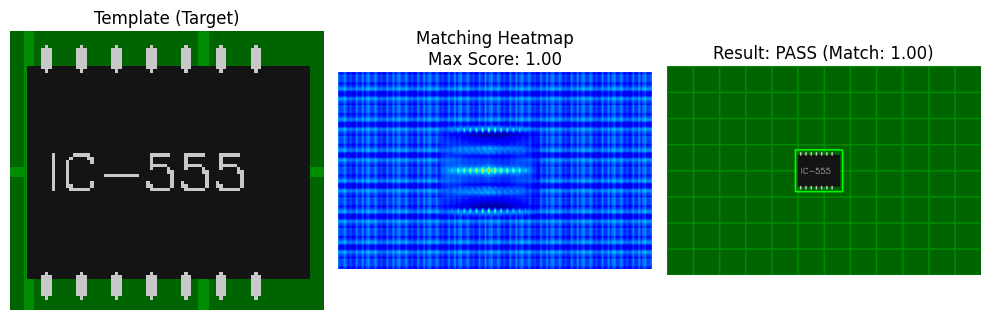


--- TEST 2: Defective Board ---


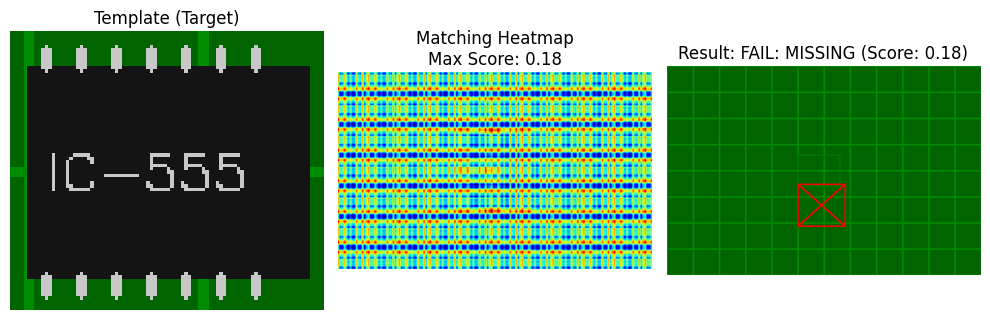

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inspect_pcb_component(board_path, template_path):
    img_rgb = cv2.imread(board_path)
    template = cv2.imread(template_path)

    if img_rgb is None or template is None:
        print("Error loading images.")
        return

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    h, w = template_gray.shape
    res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    THRESHOLD = 0.8

    result_img = img_rgb.copy()

    status = "UNKNOWN"
    color = (0, 0, 0)

    if max_val >= THRESHOLD:
        status = f"PASS (Match: {max_val:.2f})"
        color = (0, 255, 0)
        cv2.rectangle(result_img, top_left, bottom_right, color, 2)
    else:
        status = f"FAIL: MISSING (Score: {max_val:.2f})"
        color = (0, 0, 255)
        cv2.rectangle(result_img, top_left, bottom_right, color, 2)

        cv2.line(result_img, top_left, bottom_right, color, 2)
        cv2.line(result_img, (top_left[0], bottom_right[1]), (bottom_right[0], top_left[1]), color, 2)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title("Template (Target)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(res, cmap='jet')
    plt.title(f"Matching Heatmap\nMax Score: {max_val:.2f}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Result: {status}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

print("--- TEST 1: Golden Board ---")
inspect_pcb_component('/content/golden_pcb.png', '/content/component_template.png')

print("\n--- TEST 2: Defective Board ---")
inspect_pcb_component('/content/defective_pcb.png', '/content/component_template.png')

***Precisely localize PCB defects via golden template alignment and adaptive keypoints.***

Aligning images using ORB Keypoints...
Comparing aligned images...


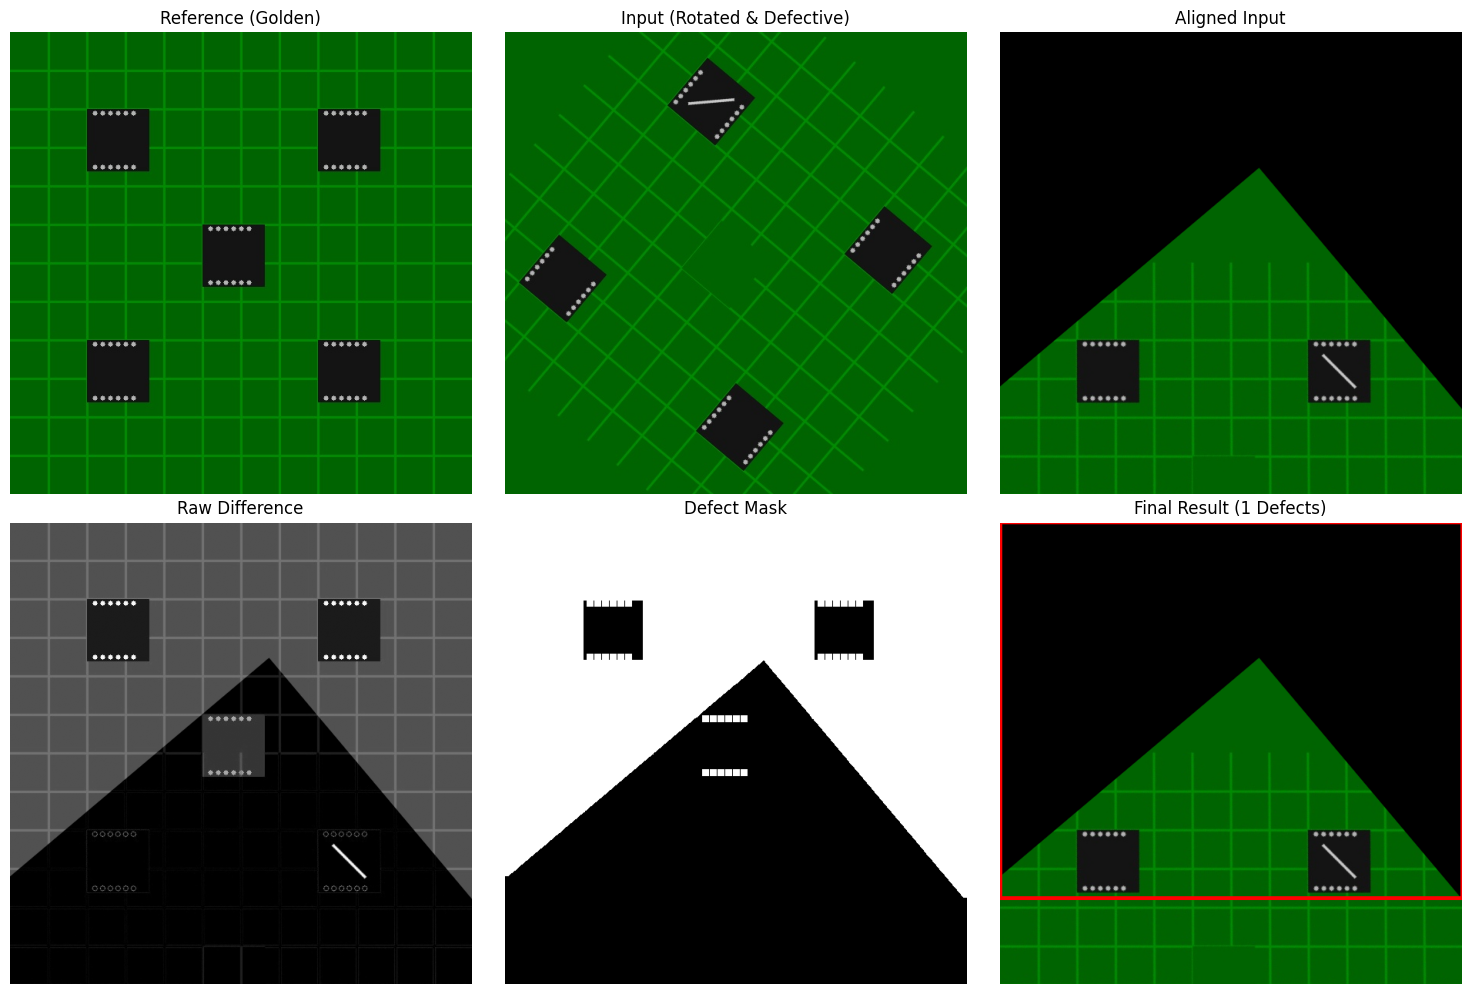

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def align_and_inspect(golden_path, defective_path):
    img_golden = cv2.imread(golden_path)
    img_defective = cv2.imread(defective_path)

    gray_golden = cv2.cvtColor(img_golden, cv2.COLOR_BGR2GRAY)
    gray_defective = cv2.cvtColor(img_defective, cv2.COLOR_BGR2GRAY)

    print("Aligning images using ORB Keypoints...")

    orb = cv2.ORB_create(5000)

    kp1, des1 = orb.detectAndCompute(gray_golden, None)
    kp2, des2 = orb.detectAndCompute(gray_defective, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)

    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = matches[:int(len(matches) * 0.15)]

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    h, w = gray_golden.shape
    img_aligned = cv2.warpPerspective(img_defective, H, (w, h))

    print("Comparing aligned images...")

    gray_aligned = cv2.cvtColor(img_aligned, cv2.COLOR_BGR2GRAY)

    diff = cv2.absdiff(gray_golden, gray_aligned)

    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    result_img = img_aligned.copy()

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    defects_found = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:
            defects_found += 1
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 0, 255), 3)
            cv2.putText(result_img, "DEFECT", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img_golden, cv2.COLOR_BGR2RGB))
    plt.title("Reference (Golden)")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(img_defective, cv2.COLOR_BGR2RGB))
    plt.title("Input (Rotated & Defective)")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(img_aligned, cv2.COLOR_BGR2RGB))
    plt.title("Aligned Input")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(diff, cmap='gray')
    plt.title("Raw Difference")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(thresh, cmap='gray')
    plt.title("Defect Mask")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Final Result ({defects_found} Defects)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

align_and_inspect('/content/golden.jpg','/content/defective_rotated(1).jpg')

***Segment and classify surface defects using rule based pipelines***

Detected 23 potential defects.

Defect: Patch | Area: 79.0 | Circularity: 0.35 | Aspect Ratio: 0.35


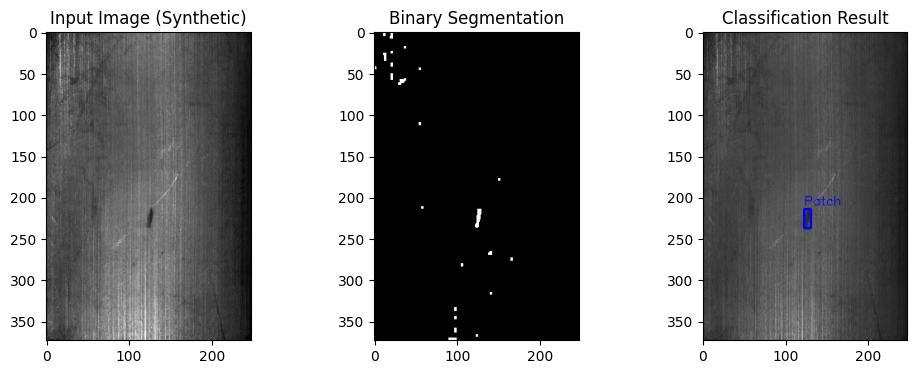

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def analyze_defects(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    blur = cv2.GaussianBlur(gray, (5, 5), 255)

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 3)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    print(f"Detected {len(contours)} potential defects.\n")

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area < 50:
            continue

        perimeter = cv2.arcLength(cnt, True)

        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h if h > w else float(h) / w

        if perimeter == 0: continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        defect_type = "Unknown"
        color = (0, 255, 255)
        if aspect_ratio > 3 and circularity < 0.5:
            defect_type = "Scratch"
            color = (0, 0, 255)
        elif circularity > 0.7:
            defect_type = "Hole"
            color = (0, 255, 0)
        else:
            defect_type = "Patch"
            color = (255, 0, 0)
        cv2.rectangle(result_img, (x, y), (x + w, y + h), color, 2)

        cv2.putText(result_img, f"{defect_type}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        print(f"Defect: {defect_type} | Area: {area:.1f} | Circularity: {circularity:.2f} | Aspect Ratio: {aspect_ratio:.2f}")

    return gray, th
input_image=cv2.imread("/content/exp1_num_108719.jpg")
gray_img, binary_mask, final_output = analyze_defects(input_image)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image (Synthetic)")
plt.imshow(gray_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Binary Segmentation")
plt.imshow(binary_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Classification Result")
plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))

plt.show()

***Analyze IR thermal maps to detect abnormal heating zones***

Global Max Intensity: 255.0 (Simulated Temp: 100.0°C)
Threshold Set At: 204
Found 20 abnormal heating zones.

Zone at (88,250): Max Temp 88.4°C | Area: 54.5
Zone at (55,236): Max Temp 86.5°C | Area: 79.0
Zone at (35,224): Max Temp 86.2°C | Area: 113.0
Zone at (165,185): Max Temp 88.4°C | Area: 128.0
Zone at (73,174): Max Temp 89.0°C | Area: 149.0
Zone at (39,170): Max Temp 94.0°C | Area: 552.5
Zone at (100,153): Max Temp 88.1°C | Area: 141.0
Zone at (114,138): Max Temp 87.8°C | Area: 189.0
Zone at (187,129): Max Temp 87.8°C | Area: 52.5
Zone at (25,128): Max Temp 88.4°C | Area: 658.5
Zone at (135,73): Max Temp 100.0°C | Area: 1350.5
Zone at (124,63): Max Temp 87.1°C | Area: 71.0


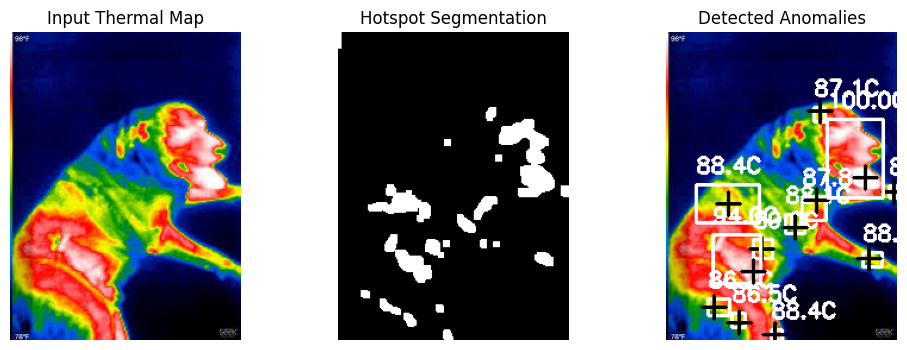

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def map_pixel_to_temp(pixel_val, min_temp=20, max_temp=100):

    return min_temp + (pixel_val / 255.0) * (max_temp - min_temp)

def detect_hotspots(image, threshold_percent=0.85):

    output = image.copy()

    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(gray)

    thresh_value = int(max_val * threshold_percent)

    _, mask = cv2.threshold(gray, thresh_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Global Max Intensity: {max_val} (Simulated Temp: {map_pixel_to_temp(max_val):.1f}°C)")
    print(f"Threshold Set At: {thresh_value}")
    print(f"Found {len(contours)} abnormal heating zones.\n")

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 50: continue
        x, y, w, h = cv2.boundingRect(cnt)

        roi = gray[y:y+h, x:x+w]
        _, local_max_val, _, local_max_loc = cv2.minMaxLoc(roi)

        temp_c = map_pixel_to_temp(local_max_val)

        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 255, 255), 2)

        global_max_pt = (x + local_max_loc[0], y + local_max_loc[1])
        cv2.drawMarker(output, global_max_pt, (0, 0, 0), cv2.MARKER_CROSS, 20, 2)

        label = f"{temp_c:.1f}C"
        cv2.putText(output, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        print(f"Zone at ({x},{y}): Max Temp {temp_c:.1f}°C | Area: {area}")

    return gray, mask, output

input_img=cv2.imread("/content/download.jpg")
gray_map, hot_mask, final_result = detect_hotspots(input_img, threshold_percent=0.80)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Thermal Map")
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Hotspot Segmentation")
plt.imshow(hot_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Detected Anomalies")
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

***Using visual analytics, detect thermal anomalies in images with annotated hot spots.***

/tmp/ipython-input-4073167201.py:98: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(gray_map.ravel(), 256, [0, 256], color='gray', alpha=0.7)


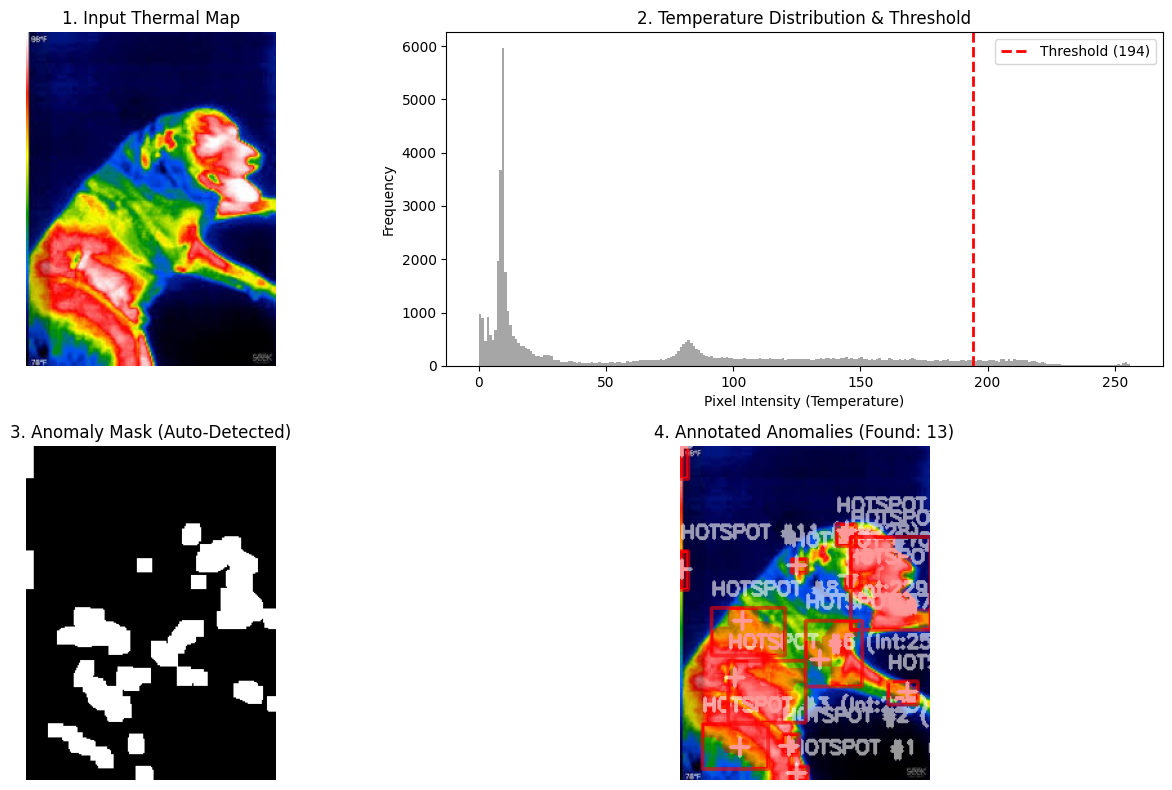

--- ANOMALY REPORT ---
Statistical Threshold Used: 194.40 (Mean + 1.8 * StdDev)
Anomaly #1: Area=127.0px | Peak Intensity=229.0
Anomaly #2: Area=172.0px | Peak Intensity=221.0
Anomaly #3: Area=676.0px | Peak Intensity=225.0
Anomaly #5: Area=314.0px | Peak Intensity=226.0
Anomaly #6: Area=1405.5px | Peak Intensity=250.0
Anomaly #7: Area=1044.5px | Peak Intensity=227.0
Anomaly #8: Area=1242.5px | Peak Intensity=229.0
Anomaly #9: Area=110.0px | Peak Intensity=223.0
Anomaly #10: Area=110.0px | Peak Intensity=222.0
Anomaly #11: Area=145.0px | Peak Intensity=228.0
Anomaly #12: Area=2262.5px | Peak Intensity=255.0
Anomaly #13: Area=206.0px | Peak Intensity=224.0
Anomaly #14: Area=120.0px | Peak Intensity=254.0


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_thermal_anomalies(image, sensitivity=2.0):
    original = image.copy()
    output_annotated = image.copy()
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()


    mean_temp = np.mean(gray)
    std_dev_temp = np.std(gray)



    threshold_value = mean_temp + (sensitivity * std_dev_temp)


    threshold_value = min(threshold_value, 255)


    _, binary_mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)


    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    binary_mask = cv2.dilate(binary_mask, np.ones((5,5), np.uint8), iterations=2)


    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    overlay = output_annotated.copy()

    anomalies_found = []

    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area < 100: continue


        x, y, w, h = cv2.boundingRect(cnt)


        roi = gray[y:y+h, x:x+w]
        _, max_val, _, max_loc = cv2.minMaxLoc(roi)
        global_max_pt = (x + max_loc[0], y + max_loc[1])


        anomalies_found.append({
            'id': i+1,
            'max_intensity': max_val,
            'area': area
        })



        cv2.drawContours(overlay, [cnt], -1, (0, 0, 255), -1)


        cv2.rectangle(output_annotated, (x, y), (x + w, y + h), (0, 0, 255), 2)


        cv2.drawMarker(output_annotated, global_max_pt, (255, 255, 255), cv2.MARKER_CROSS, 15, 2)


        label = f"HOTSPOT #{i+1} (Int:{int(max_val)})"
        cv2.putText(output_annotated, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)


    alpha = 0.4
    cv2.addWeighted(overlay, alpha, output_annotated, 1 - alpha, 0, output_annotated)

    return gray, binary_mask, output_annotated, threshold_value, anomalies_found

input_img=cv2.imread("/content/download.jpg")
gray_map, mask, result_img, thresh_val, stats = analyze_thermal_anomalies(input_img, sensitivity=1.8)

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.title("1. Input Thermal Map")
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("2. Temperature Distribution & Threshold")
plt.hist(gray_map.ravel(), 256, [0, 256], color='gray', alpha=0.7)
plt.axvline(thresh_val, color='r', linestyle='dashed', linewidth=2, label=f'Threshold ({int(thresh_val)})')
plt.legend()
plt.xlabel("Pixel Intensity (Temperature)")
plt.ylabel("Frequency")

plt.subplot(2, 2, 3)
plt.title("3. Anomaly Mask (Auto-Detected)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"4. Annotated Anomalies (Found: {len(stats)})")
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

print("--- ANOMALY REPORT ---")
print(f"Statistical Threshold Used: {thresh_val:.2f} (Mean + 1.8 * StdDev)")
for stat in stats:
    print(f"Anomaly #{stat['id']}: Area={stat['area']}px | Peak Intensity={stat['max_intensity']}")

***Capture depth maps using stereo cameras or structured light and detect surface dents and depth variations.***

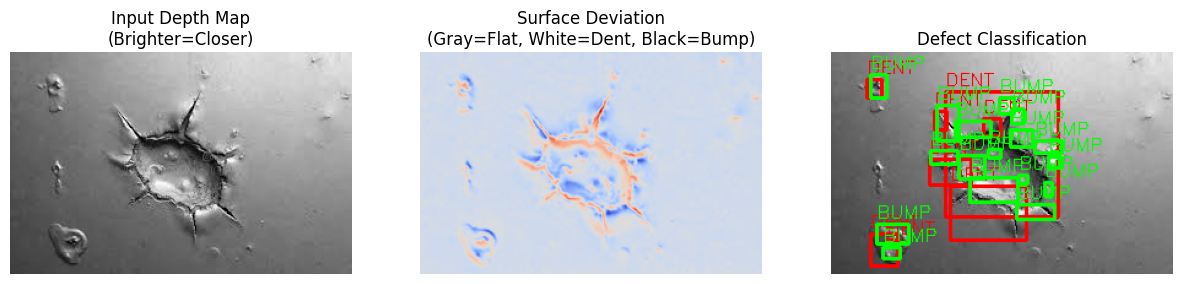

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_disparity_map(imgL, imgR):
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*5,
        blockSize=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )

    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0


    disp_norm = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return disp_norm

def detect_depth_anomalies(depth_map, sensitivity_thresh=15):
    denoised = cv2.GaussianBlur(depth_map, (3, 3), 0)

    background_model = cv2.GaussianBlur(denoised, (51, 51), 0)

    diff = background_model.astype(np.int16) - denoised.astype(np.int16)

    _, dent_mask = cv2.threshold(diff, sensitivity_thresh, 255, cv2.THRESH_BINARY)

    _, bump_mask = cv2.threshold(-diff, sensitivity_thresh, 255, cv2.THRESH_BINARY)

    dent_mask = dent_mask.astype(np.uint8)
    bump_mask = bump_mask.astype(np.uint8)

    output = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2BGR)

    contours_dent, _ = cv2.findContours(dent_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours_dent:
        if cv2.contourArea(cnt) < 20: continue
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 0, 255), 2) # Red for Dent
        cv2.putText(output, "DENT", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    contours_bump, _ = cv2.findContours(bump_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours_bump:
        if cv2.contourArea(cnt) < 20: continue
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2) # Green for Bump
        cv2.putText(output, "BUMP", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return diff, output

depth_map =cv2.imread("/content/download (3).jpg", cv2.IMREAD_GRAYSCALE)

difference_map, final_result = detect_depth_anomalies(depth_map, sensitivity_thresh=20)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Depth Map\n(Brighter=Closer)")
plt.imshow(depth_map, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Surface Deviation\n(Gray=Flat, White=Dent, Black=Bump)")
plt.imshow(difference_map, cmap='coolwarm')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Defect Classification")
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Assignment

***Given a set of images of the same part under 3 lighting setups and 3 view angles, design preprocessing that stabilizes defect decisions across conditions.***

Initializing Stabilizer with Reference Image...


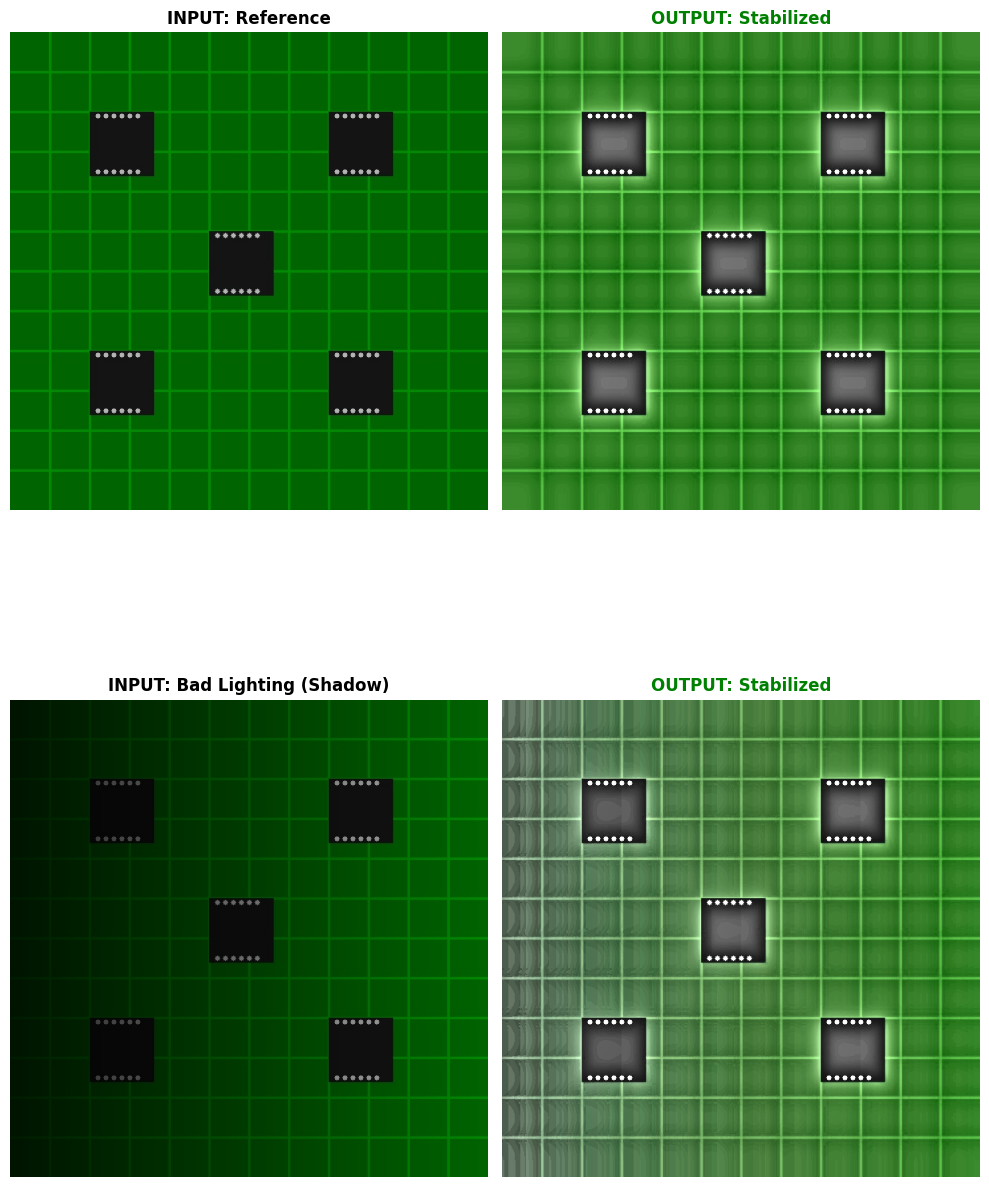

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ImageStabilizer:
    def __init__(self, reference_image):
        self.ref_img = reference_image

        if len(reference_image.shape) == 3:
            self.ref_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
        else:
            self.ref_gray = reference_image

        self.height, self.width = self.ref_gray.shape

        self.orb = cv2.ORB_create(nfeatures=2000)
        self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        self.kp_ref, self.des_ref = self.orb.detectAndCompute(self.ref_gray, None)

    def normalize_illumination(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        l, a, b = cv2.split(lab)

        illumination_map = cv2.GaussianBlur(l, (61, 61), 0)

        corrected_l = (l.astype(np.float32) / (illumination_map.astype(np.float32) + 1.0)) * 128.0
        corrected_l = np.clip(corrected_l, 0, 255).astype(np.uint8)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_l = clahe.apply(corrected_l)

        merge = cv2.merge((enhanced_l, a, b))
        final_bgr = cv2.cvtColor(merge, cv2.COLOR_Lab2BGR)

        return final_bgr

    def align_geometry(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


        kp, des = self.orb.detectAndCompute(gray, None)

        if des is None: return img

        matches = self.matcher.match(self.des_ref, des)
        matches = sorted(matches, key=lambda x: x.distance)


        good_matches = matches[:int(len(matches) * 0.2)]

        if len(good_matches) < 4: return img


        src_pts = np.float32([self.kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)


        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

        if H is None: return img

        aligned_img = cv2.warpPerspective(img, H, (self.width, self.height))

        return aligned_img

    def process(self, img):

        aligned = self.align_geometry(img)
        stabilized = self.normalize_illumination(aligned)
        return stabilized
def generate_test_scenarios(base):
    scenarios = []
    rows, cols = base.shape[:2]
    M_rot = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 0.8)

    scenarios.append(("Reference", base.copy()))


    bad_light = base.copy()

    shadow = np.tile(np.linspace(0.2, 1.0, cols), (rows, 1))
    shadow = np.dstack([shadow]*3)
    bad_light = (bad_light * shadow).astype(np.uint8)
    scenarios.append(("Bad Lighting (Shadow)", bad_light))

    return scenarios

if __name__ == "__main__":

    ref = cv2.imread("/content/golden.jpg")
    dataset=generate_test_scenarios(ref)
    ref_img=dataset[0][1]

    print("Initializing Stabilizer with Reference Image...")
    stabilizer = ImageStabilizer(ref_img)


    fig, axes = plt.subplots(len(dataset), 2, figsize=(10, 15))

    for i, (name, raw_img) in enumerate(dataset):

        if name == "Reference":
            processed = stabilizer.normalize_illumination(raw_img)
        else:
            processed = stabilizer.process(raw_img)


        axes[i, 0].imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"INPUT: {name}", fontweight='bold')
        axes[i, 0].axis('off')


        axes[i, 1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        axes[i, 1].set_title("OUTPUT: Stabilized", fontweight='bold', color='green')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

***Train a seam quality classifier on Site A; test on Site B with different camera and lighting setups***

Generating Site A Data (Training)...
Generating Site B Data (Testing - Different Light/Camera)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Model on Site A Data ---
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.5964 - loss: 0.6617 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 6.2777e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 1.0000 - loss: 4.7573e-05 - val_accuracy: 1.0000 - val_loss: 2.6424e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 1.0000 - loss: 2.9918e-05 - val_accuracy: 1.0000 - val_loss: 2.0924e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 1.0000 - loss: 2.6529e-05 - val_accuracy: 1.0000 - val_loss: 1.5710e-05

--- Evaluating on Site B (Unseen Domain) ---
Accuracy on Site B: 87.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


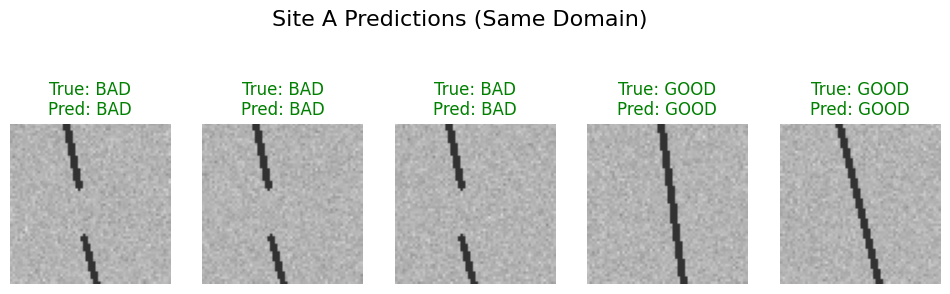

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


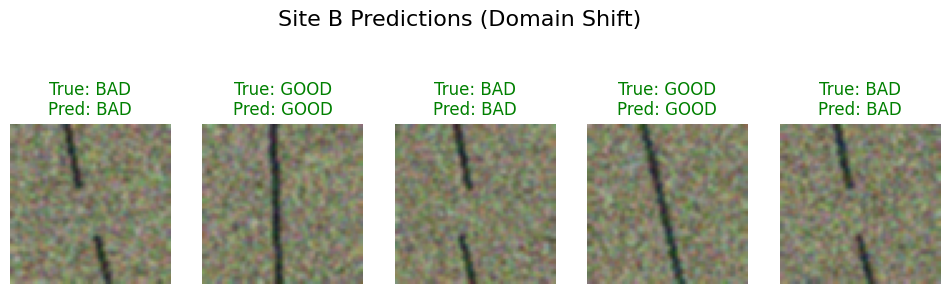

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

def generate_seam_image(site_type='A', is_defective=False):

    width, height = 64, 64

    if site_type == 'A':

        img = np.random.normal(180, 10, (height, width)).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:

        img = np.random.normal(100, 30, (height, width)).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        yellow_mask = np.full((height, width, 3), (0, 30, 30), dtype=np.uint8)
        img = cv2.add(img, yellow_mask)

    start_x = np.random.randint(20, 30)
    end_x = np.random.randint(30, 40)

    color = (50, 50, 50) if site_type == 'A' else (30, 30, 20) # Dark line
    thickness = 2

    if is_defective:

        cv2.line(img, (start_x, 0), (start_x + 5, 25), color, thickness)
        cv2.line(img, (end_x - 5, 45), (end_x, 64), color, thickness)
    else:

        cv2.line(img, (start_x, 0), (end_x, 64), color, thickness)


    if site_type == 'B':

        noise = np.random.normal(0, 15, img.shape).astype(np.uint8)
        img = cv2.addWeighted(img, 0.8, noise, 0.2, 0)

        img = cv2.GaussianBlur(img, (3, 3), 0)

    return img

def create_dataset(samples=1000, site_type='A'):
    X = []
    y = []
    for _ in range(samples):

        is_defect = np.random.rand() > 0.5
        img = generate_seam_image(site_type, is_defect)
        X.append(img)
        y.append(1 if is_defect else 0)
    return np.array(X), np.array(y)

def standardize_input(images):
    images = images.astype('float32') / 255.0
    return images

print("Generating Site A Data (Training)...")
X_train_raw, y_train = create_dataset(samples=2000, site_type='A')

print("Generating Site B Data (Testing - Different Light/Camera)...")
X_test_raw, y_test = create_dataset(samples=500, site_type='B')

X_train = standardize_input(X_train_raw)
X_test = standardize_input(X_test_raw)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Training Model on Site A Data ---")
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

print("\n--- Evaluating on Site B (Unseen Domain) ---")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on Site B: {acc*100:.2f}%")
def visualize_predictions(X_raw, y_true, model_input, title):
    preds = model.predict(model_input)
    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=16)

    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(X_raw[i], cv2.COLOR_BGR2RGB))

        true_label = "BAD" if y_true[i] == 1 else "GOOD"
        pred_label = "BAD" if preds[i] > 0.5 else "GOOD"
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.show()

visualize_predictions(X_train_raw[:5], y_train[:5], X_train[:5], "Site A Predictions (Same Domain)")

visualize_predictions(X_test_raw[:5], y_test[:5], X_test[:5], "Site B Predictions (Domain Shift)")

***Set an alarm that detects true hot spot events in IR sequences while keeping false alarms rare.***

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marcosgabriel/infrared-solar-modules")

print("Path:", path)

Using Colab cache for faster access to the 'infrared-solar-modules' dataset.
Path: /kaggle/input/infrared-solar-modules


Starting IR Sequence Analysis...
Yellow = Potential Candidate
Red = Confirmed True Alarm


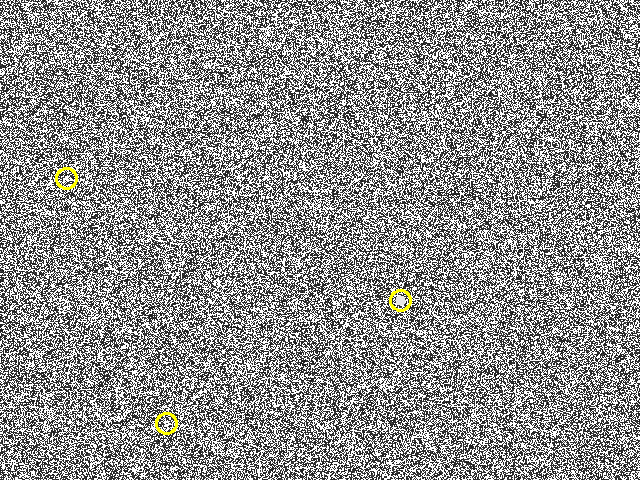

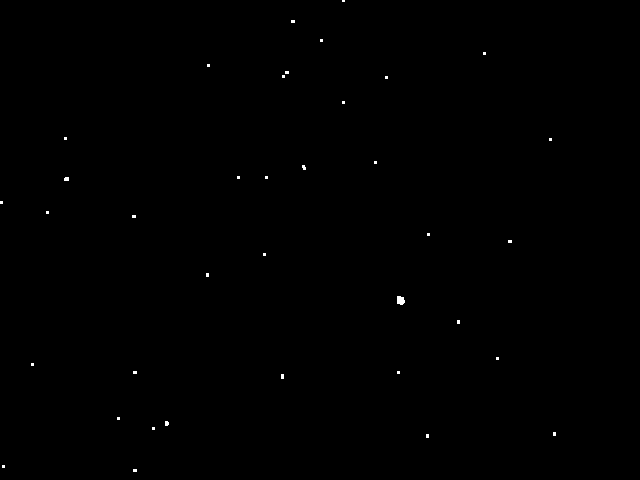

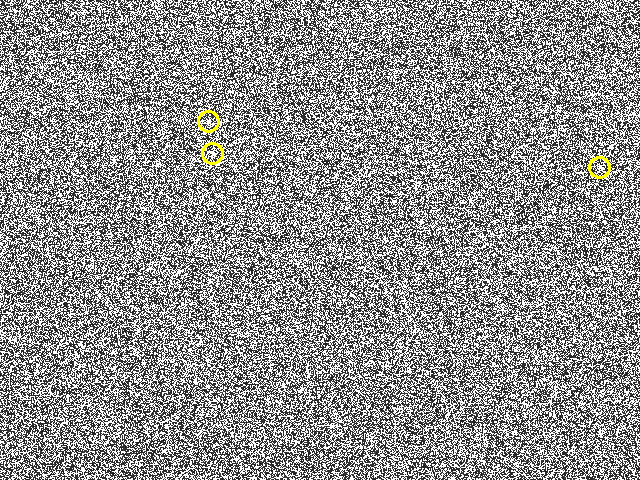

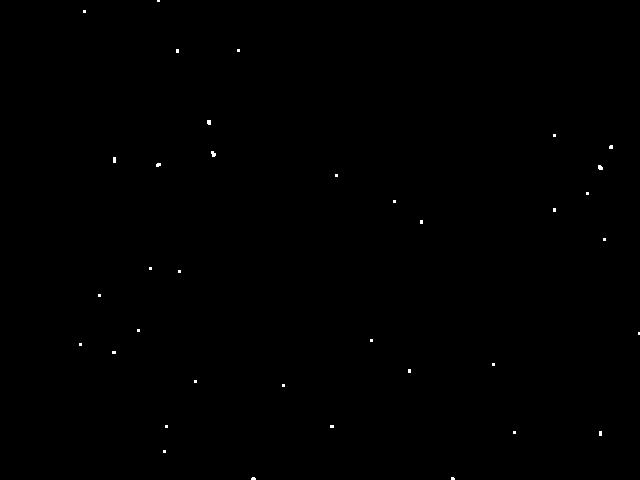

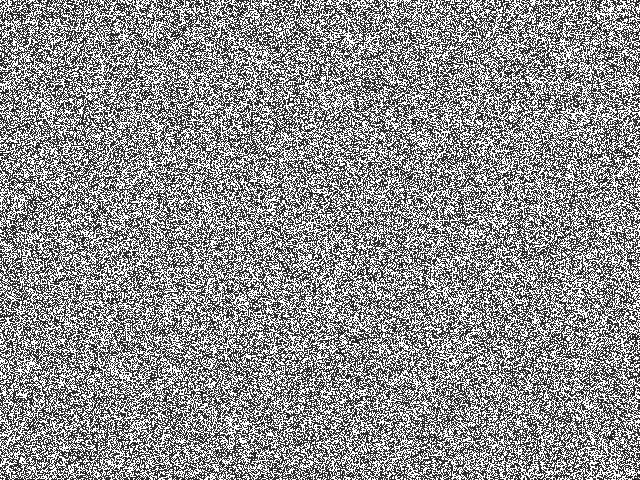

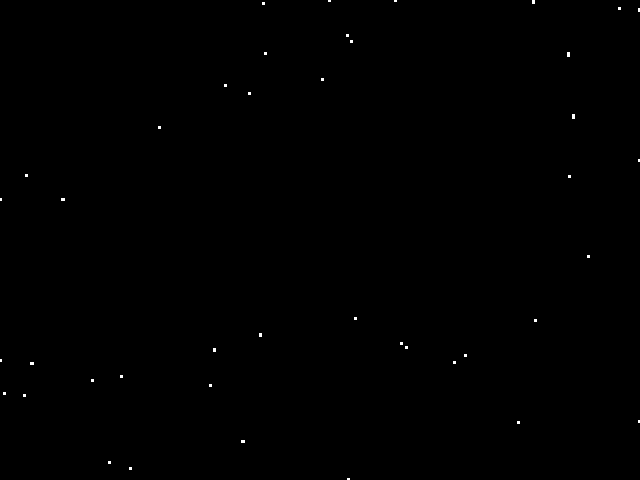

In [20]:
import cv2
import numpy as np
import time
from collections import deque
from google.colab.patches import cv2_imshow
import glob

class IRHotspotDetector:
    def __init__(self, threshold=200, min_area=5, persistence_frames=5):
        self.threshold = threshold
        self.min_area = min_area
        self.persistence_frames = persistence_frames

        self.candidates = {}
        self.next_candidate_id = 0
        self.max_distance = 20

    def process_frame(self, frame_bgr):

        gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)


        blurred = cv2.GaussianBlur(gray, (5, 5), 0)



        _, mask = cv2.threshold(blurred, self.threshold, 255, cv2.THRESH_BINARY)


        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)


        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        current_frame_centroids = []


        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > self.min_area:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    current_frame_centroids.append((cX, cY))

                    cv2.circle(frame_bgr, (cX, cY), 10, (0, 255, 255), 2)


        self._update_tracking(current_frame_centroids, frame_bgr)

        return frame_bgr, mask

    def _update_tracking(self, current_centroids, display_frame):

        new_candidates = {}
        used_current_centroids = set()


        for c_id, data in self.candidates.items():
            old_x, old_y = data['position']
            best_match_idx = -1
            min_dist = self.max_distance

            for idx, (curr_x, curr_y) in enumerate(current_centroids):
                if idx in used_current_centroids:
                    continue

                dist = np.sqrt((old_x - curr_x)**2 + (old_y - curr_y)**2)
                if dist < min_dist:
                    min_dist = dist
                    best_match_idx = idx

            if best_match_idx != -1:

                streak = data['streak'] + 1
                new_pos = current_centroids[best_match_idx]


                if streak >= self.persistence_frames:
                    self._trigger_alarm(display_frame, new_pos, streak)

                new_candidates[c_id] = {'streak': streak, 'position': new_pos}
                used_current_centroids.add(best_match_idx)
            else:


                pass


        for idx, pos in enumerate(current_centroids):
            if idx not in used_current_centroids:
                new_candidates[self.next_candidate_id] = {'streak': 1, 'position': pos}
                self.next_candidate_id += 1

        self.candidates = new_candidates

    def _trigger_alarm(self, frame, position, streak):

        x, y = position


        cv2.circle(frame, (x, y), 20, (0, 0, 255), 3)
        cv2.putText(frame, f"ALARM! Hotspot Detected ({streak} f)", (x - 60, y - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)


        print(f"[ALARM] True Hot Spot confirmed at {position} - Persisted for {streak} frames.")


def generate_synthetic_ir_stream(frames=3, width=640, height=480):

    background = np.random.randint(20, 50, (height, width), dtype=np.uint8)


    true_x, true_y = 100, 100

    for i in range(frames):
        frame = background.copy()


        noise = np.random.normal(0, 15, frame.shape).astype(np.uint8)
        frame = cv2.add(frame, noise)


        if i > 10:
            true_x += 1
            cv2.circle(frame, (true_x, true_y), 8, (255), -1)



        if i % 5 == 0:
            cv2.circle(frame, (400, 300), 5, (230), -1)


        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        yield frame_bgr

detector = IRHotspotDetector(threshold=200, min_area=10, persistence_frames=10)

print("Starting IR Sequence Analysis...")
print("Yellow = Potential Candidate")
print("Red = Confirmed True Alarm")

frame_generator = generate_synthetic_ir_stream(frames=3)

for frame in frame_generator:
    output_frame, mask = detector.process_frame(frame)
    cv2_imshow(output_frame)
    cv2_imshow(mask)